# rewrite loading xyz using ase

# Tasks
1. improve get_pairs, removes all the pairs list/dictionaries
2. finish excel writting

In [1]:
# -----------------------------------------------------------------------------
# :author:    Juanjuan Huang & Shelly D. Keylly
# :email:     juanjuan.huang@anl.gov
# :copyright: Copyright © 2023, UChicago Argonne, LLC
# -----------------------------------------------------------------------------


In [81]:
import py3Dmol
import numpy as np
import matplotlib.pyplot as plt
from ipyfilechooser import FileChooser
from ase.io import read
from ase.io import write
import plotly.graph_objects as go
from pprint import pprint
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
from scipy.spatial.distance import pdist
from ase.neighborlist import NeighborList, natural_cutoffs
from scipy.optimize import curve_fit
from collections import defaultdict
from ase.geometry import cell_to_cellpar
import pandas as pd
from openpyxl import Workbook
from itertools import combinations
from itertools import product

%matplotlib widget


In [3]:
def fit_polynomial(x, y, degree):
    """
    Fit a polynomial of the given degree to the provided points.
    
    Parameters:
    points (list of float): The points to fit the polynomial to.
    degree (int): The degree of the polynomial to fit.
    
    Returns:
    np.poly1d: The fitted polynomial.
    """
    # Fit the polynomial
    coeffs = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coeffs)
    
    # Create the polynomial equation as a string
    equation = "y = " + " + ".join([f"{coeff:.2f}x^{deg}" if deg > 0 else f"{coeff:.2f}" 
                                    for deg, coeff in enumerate(coeffs[::-1])])
    plt.figure()
    # Plot the points and the fitted polynomial
    plt.scatter(x, y, color='red', label='Data Points')
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = polynomial(x_fit)
    plt.plot(x_fit, y_fit, color='blue', label=f'Polynomial Fit (degree {degree})')
    # plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Polynomial Fit to Points')
    # Display the polynomial equation on the plot
    plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    
    plt.show()
    
    return polynomial

def fit_logarithmic(x, y):
    """
    Fit a logarithmic function to the provided points.
    
    Parameters:
    x (list of float): The x values of the points.
    y (list of float): The y values of the points.
    
    Returns:
    tuple: The parameters of the fitted logarithmic function.
    """
    # Define the logarithmic function
    def log_func(x, a, b, c):
        return a * np.log(b * x) + c

    # Fit the logarithmic function to the data
    popt, _ = curve_fit(log_func, x, y, maxfev=10000)

    # Create the logarithmic equation as a string
    a, b, c = popt
    equation = f"y = {a:.2f} * log({b:.2f} * x) + {c:.2f}"

    # Generate x values for plotting the fit
    x_fit = np.linspace(min(x), max(x), 100)
    # Generate y values using the fitted logarithmic function
    y_fit_log = log_func(x_fit, *popt)

    # Plot the data points and the logarithmic fit
    plt.figure()
    plt.scatter(x, y, color='red', label='Data Points')
    plt.plot(x_fit, y_fit_log, color='blue', label='Logarithmic Fit')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Logarithmic Fit to Points')
    # Display the logarithmic equation on the plot
    plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.show()

    return popt

# Class ClusterNeighbor

In [376]:
class ClusterNeighbor:
    def __init__(self):
        """Initialize the ClusterNeighbor class.
        """
        self.atoms = None
        self.folder = '.'
        self.xyz_string = ""
        self._init_parameters()

    def _init_parameters(self):
        """Initialize the parameters of the class.
        """
        self.center = None
        self.pairs_index = []
        self.pairs_element = []
        self.distance_all = []
        self.pairs_types = set()
        self.CN_distances = defaultdict(list)
        self.CN = {}
        self.CN_summary = defaultdict(lambda: defaultdict(dict))  # Initialize CN_summary as a nested defaultdict
        self.cluster_size = 0
        self.indices = None

    def refresh_atoms(self):
        """ 
        When self.atoms is updated, refresh the parameters.
        """
        self._init_parameters()
        self.xyz_string = f"{len(self.atoms)}\n\n" + "\n".join(
            f"{atom.symbol} {atom.position[0]} {atom.position[1]} {atom.position[2]}" for atom in self.atoms
        )
        # get the elements and their counts            
        self.elements = self.atoms.get_chemical_symbols()
        unique_elements, counts = np.unique(self.elements, return_counts=True)
        self.elements_num = dict(zip(unique_elements, counts))
        
        # get pairs types
        self.pairs_types = set([f"{atom_i}-{atom_j}" for atom_i, atom_j in product(unique_elements, repeat=2)])

        # get the index of each element
        self.element_index_group = {element: [i for i, e in enumerate(self.elements) if e == element] for element in set(self.elements)}
        self.center = self.atoms.get_center_of_mass()
        
        # Create the XYZ string for visualization
        self.xyz_string = f"{len(self.atoms)}\n\n" 
        for atom in self.atoms:
            self.xyz_string += f"{atom.symbol} {atom.position[0]} {atom.position[1]} {atom.position[2]}\n"

    def _calculate_distance(self, coord1, coord2):
        """Calculate the Euclidean distance between two sets of coordinates.

        Args:
        coord1 (list): The first set of coordinates.
        coord2 (list): The second set of coordinates.
        
        Returns:
        float: The Euclidean distance between the two sets of coordinates.
        """
        return np.linalg.norm(np.array(coord1) - np.array(coord2))

    def load_xyz(self, from_file=True, path=None, atom_object=None):
        """Load the atomic cluster from an XYZ file or an ASE Atoms object.

        Args:
        from_file (bool): Whether to load the cluster from a file. Defaults to True.
        path (str): The path to the XYZ file. Defaults to None.
        atom_object (Atoms): The ASE Atoms object representing the atomic cluster. Defaults to None.
        
        Raises:
        ValueError: If neither a file path nor an ASE Atoms object is provided.
        
        Returns:
        Atoms: The ASE Atoms object representing the atomic cluster.
        """
        # Load the atoms from a file or an object
        if from_file:
            self.atoms = read(path)
            self.folder = os.path.dirname(path)
        else:
            self.atoms = atom_object
        
        self.refresh_atoms()
    
    def save(self, filename):
        """Save the atomic cluster to an XYZ file.

        Args:
        filename (str): The name of the file to save the atomic cluster to.
        
        Returns:
        Atoms: The ASE Atoms object representing the atomic cluster.
        """
        write(filename, self.atoms)

    def expand_cif(self, replication_factors=(2, 2, 2), self_apply=False):
        """ Expand the cluster by replicating it in all three dimensions.

        Args:
            replication_factors (tuple): The number of times to replicate the cluster in each dimension.
            self_apply (bool): Whether to apply the expansion to the current cluster.
        Returns:
            expanded_cluster (Atoms): The expanded cluster.
        """
        expanded_cluster = self.atoms.repeat(replication_factors)
        if self_apply:
            self.atoms = expanded_cluster 
            self.refresh_atoms()
        return expanded_cluster

    def view_xyz(self, style_all=None, highlight_atom1="O", highlight_atom2="Pb", label=False, show_symbol=False):
        """Visualize the atomic cluster using py3Dmol.

        Args:
            style_all (_type_, optional): _description_. Defaults to None.
            highlight_atom1 (str, optional): _description_. Defaults to "O".
            highlight_atom2 (str, optional): _description_. Defaults to "Pb".
            label (bool, optional): _description_. Defaults to False.
            show_symbol (bool, optional): _description_. Defaults to False.
        """
        view = py3Dmol.view(width=400, height=400)
        
        # Add the model to the view
        view.addModel(self.xyz_string, 'xyz')
        
        if style_all is None:
            style_all = {'stick': {'radius': .1, 'alpha': 0.2, 'color': 'gray'}, 
                         'sphere': {'radius': .3}}
        view.setStyle(style_all)
        view.addStyle({'atom': highlight_atom1}, {'sphere': {'color': 'red', 'radius': 0.5}})
        view.addStyle({'atom': highlight_atom2}, {'sphere': {'color': 'blue', 'radius': 0.3}})
        view.setBackgroundColor('0xeeeeee')

        if label:
            for i, atom in enumerate(self.atoms):
                symbol = atom.symbol if show_symbol else ""
                view.addLabel(f"{i}{symbol}", {'position': {'x': atom.position[0], 'y': atom.position[1], 'z': atom.position[2]}, 
                                    'fontColor': 'k', 'fontSize': 12, 'backgroundColor': 'white', 'backgroundOpacity': 0.5})
        
        view.zoomTo()
        view.show()
        view.title(self.atoms.get_chemical_formula())

        # Assign the new view to the instance variable
        self.view = view

    def get_cluster_size(self):
        """Estimate the cluster size using the maximum pairwise distance method.

        Returns:
        float: Approximate cluster size.
        """
        positions = self.atoms.get_positions()
        distances = pdist(positions)
        self.cluster_size = np.max(distances) / 2
        return self.cluster_size
    
    def get_cluster_size_bounding_box(self):
            """
            Estimate the cluster size using the bounding box method.

            Returns:
            float: Approximate cluster size.
            """
            cellpar = cell_to_cellpar(self.atoms.get_cell())
            max_dimension = max(cellpar[:3])
            return max_dimension

    def shrink_cluster_size(self, new_radius=None, center_atom_index=None, self_apply=False):
        """Shrink the cluster size by removing atoms outside a specified radius.

        Args:
            new_radius (_type_, optional): _description_. Defaults to None.
            center_atom_index (_type_, optional): _description_. Defaults to None.
            self_apply (bool, optional): _description_. Defaults to False.

        Returns:
            atoms: The shrunken cluster.
        """
        if new_radius is None:
            new_radius = self.cluster_size - 0.1
        center = self.atoms[center_atom_index].position if center_atom_index is not None else self.center
        distances = np.linalg.norm(self.atoms.positions - center, axis=1)
        mask = distances <= new_radius
        atoms_smaller = self.atoms[mask]
        if self_apply:
            self.atoms = atoms_smaller
            self.refresh_atoms()
        return atoms_smaller

    def get_CN(self, center_atom=None, CN_atom=None, tolerance=0.01, bond_range=5, printit=True):
        """
        Calculate the coordination number (CN) for a specified bond type in the atomic cluster.
 
        Args:
        center_atom (str): Symbol of the central atom type for which CN is calculated. Defaults to the first atom's symbol.
        CN_atom (str): Symbol of the neighboring atom type for which CN is calculated. Defaults to the second atom's symbol.
        bond_ranges (float): Threshold for identifying significant gaps in bond lengths. Defaults to 0.01.
        tolerance (float): Maximum distance to consider for coordination number calculations. Defaults to 5.
        printit (bool): Whether to print the results. Defaults to True.

        Returns:
        dict: A dictionary where the keys are bond lengths and the values are the calculated coordination numbers.

        Example:
        """
        if center_atom is None:
            center_atom = list(self.pairs_types)[0].split('-')[0]
        if CN_atom is None:
            CN_atom = list(self.pairs_types)[0].split('-')[1]
            
        self.tolerance = tolerance
        self.bond_range = bond_range
        
        pairs_type = f"{center_atom}-{CN_atom}"
        center_atom_index = self.element_index_group[center_atom]
        CN_atom_index = self.element_index_group[CN_atom]

        # Create a NeighborList with the specified cutoff radius
        cutoffs = [bond_range] * len(self.atoms)
        nl = NeighborList(cutoffs, skin=0.5, bothways=True, self_interaction=False)
        nl.update(self.atoms)
        
        # Calculate all distances once and filter based on CN_atom_index
        distances_all = []
        for atom_i in center_atom_index:
            indices, offsets = nl.get_neighbors(atom_i)
            indices = indices[indices != atom_i]  # Exclude self-pairing
            if len(indices) == 0:
                continue
            distances = self.atoms.get_distances(atom_i, indices, mic=True)
            mask = np.isin(indices, CN_atom_index)
            distances_all.extend(distances[mask])

        # Convert the distances to a numpy array
        distances_all = np.array(distances_all)
        if len(distances_all) == 0:
            print(f"No valid distances found for bond type {pairs_type}.")
            return self.CN
    
        # Sort the distances and remove zeros and distances beyond the bond range
        distance_sorted = np.sort(distances_all)
        distance_sorted = distance_sorted[(distance_sorted != 0) & (distance_sorted < bond_range)]
        
        # Calculate differences and identify significant gaps
        if len(distance_sorted) == 0:
            print(f"No valid sorted distances found for bond type {pairs_type}.")
            return self.CN

        # Calculate differences and identify significant gaps
        diff = np.diff(distance_sorted)
        indices = np.where(diff > tolerance)[0] + 1
        self.CN_distances[pairs_type] = np.split(distance_sorted, indices)
        self.CN[pairs_type] = {np.average(group): group.shape[0] / self.elements_num[center_atom] for group in self.CN_distances[pairs_type]}
        
        if printit:
            print("=" * 20)
            print(pairs_type)
            print("=" * 20)
            for i, lengths_key in enumerate(self.CN[pairs_type].keys()):
                print(f"{i + 1} length: {lengths_key:.3f}  CN: {self.CN[pairs_type][lengths_key]:.3f}")

        return self.CN
    
    def get_CN_all(self, tolerance=0.01, bond_range=5, printit=True):
        """Calculate the coordination numbers for all pairs of atoms in the cluster.
        
        Args:
        tolerance (float): Threshold for identifying significant gaps in bond lengths. Defaults to 0.01.
        bond_range (float): Maximum distance to consider for coordination number calculations. Defaults to 5.
        printit (bool): Whether to print the results. Defaults to True.
        
        Returns:
        dict: A dictionary where the keys are bond types and the values are dictionaries containing the bond lengths and coordination numbers.
        """
        self.CN_distances = defaultdict(list)
        self.CN = {}
        for center_atom_i in self.elements_num.keys():
            for CN_atom_i in self.elements_num.keys():
                self.get_CN(center_atom=center_atom_i, 
                            CN_atom=CN_atom_i, 
                            tolerance=tolerance, 
                            bond_range=bond_range, 
                            printit=printit)
    
    def get_CN_around_distance(self, 
                               center_atom=None, 
                               CN_atom=None, 
                               target_distance=None, 
                               shell=None,
                               tolerance=0.01, 
                               bond_range=5, 
                               printit=True
                               ):
        """
        Calculate the coordination number (CN) for atoms with bond distances around the specified value.

        Args:
        target_distance (float): The target bond distance around which to count CNs. Defaults to None.
        pairs_type (str): The bond type for which CN is calculated (e.g., "Cu-Cu"). Defaults to None.
        tolerance (float): The tolerance for considering distances around the target distance. Defaults to 0.01.
        bond_range (float): Maximum distance to consider for coordination number calculations. Defaults to 5.
        printit (bool): Whether to print the results. Defaults to True.

        Returns:
        dict: A dictionary where the keys are coordination numbers and the values are the counts of atoms with that CN.
        """
        # If pairs_type is not provided, use the first pair type in the cluster
        if center_atom is None:
            center_atom = list(self.pairs_types)[0].split('-')[0]
        if CN_atom is None:
            CN_atom = list(self.pairs_types)[0].split('-')[1]
            
        pairs_type = f"{center_atom}-{CN_atom}"

        # If target_distance is not provided, use the CN data to get the target distance
        if target_distance is None:
            if self.CN.get(pairs_type) is None:
                self.get_CN(center_atom=center_atom, CN_atom=CN_atom, tolerance=tolerance, bond_range=bond_range, printit=printit)
            if shell is None:
                shell = 1
            target_distance = list(self.CN[pairs_type].keys())[shell-1]
        
        # Get the indices of the center and CN atoms
        center_atom_index = self.element_index_group[center_atom]
        CN_atom_index = self.element_index_group[CN_atom]

        # Create a NeighborList with the specified cutoff radius
        cutoffs = [bond_range] * len(self.atoms)
        nl = NeighborList(cutoffs, skin=tolerance, bothways=True, self_interaction=False)
        nl.update(self.atoms)
        
        # Count CNs for each atom based on distances around the target distance
        atom_CN_counts = {atom_i: 0 for atom_i in center_atom_index}
        for atom_i in center_atom_index:
            indices, offsets = nl.get_neighbors(atom_i)
            indices = indices[indices != atom_i]  # Exclude self-pairing
            if len(indices) == 0:
                continue
            distances = self.atoms.get_distances(atom_i, indices, mic=True)
            mask = (distances >= target_distance - tolerance) & (distances <= target_distance + tolerance) & np.isin(indices, CN_atom_index)
            atom_CN_counts[atom_i] = np.sum(mask)
        
        # Prepare the summary list
        CN_summary = defaultdict(int)
        for cn in atom_CN_counts.values():
            CN_summary[cn] += 1

        average_CN = np.mean(list(atom_CN_counts.values()))
        info = "\n".join([f"{count} atoms have CN of {cn}" for cn, count in sorted(CN_summary.items())])

        self.CN_summary[pairs_type][target_distance] = {
            'average_CN': average_CN,
            'info': info,
            'tolerance': tolerance
        }

        if printit:
            print("=" * 20)
            print(f"Coordination numbers around {target_distance:.3f} Å for {pairs_type}")
            print("=" * 20)
            for cn, count in sorted(CN_summary.items()):
                print(f"{count} atoms have CN of {cn}")
                
        return CN_summary

    def get_CN_summary_all(self,
                        tolerance=0.01,
                        bond_range=5,
                        printit=True):
        """
        Calculate the coordination numbers for all pairs of atoms in the cluster.

        Args:
        tolerance (float): Threshold for identifying significant gaps in bond lengths. Defaults to 0.01.
        bond_range (float): Maximum distance to consider for coordination number calculations. Defaults to 5.
        printit (bool): Whether to print the results. Defaults to True.
        
        Returns:
        dict: A dictionary where the keys are bond types and the values are dictionaries containing the bond lengths and coordination numbers.
        """
        self.get_CN_all(tolerance=tolerance, bond_range=bond_range, printit=printit)
        for pair_type in self.pairs_types:
            center_atom, CN_atom = pair_type.split('-')
            for target_distance in self.CN[pair_type].keys():
                self.get_CN_around_distance(center_atom=center_atom,
                                            CN_atom=CN_atom,
                                            target_distance=target_distance,
                                            tolerance=tolerance,
                                            bond_range=bond_range,
                                            printit=printit)
        return self.CN_summary
            
    def get_pairs(self):
        """Get all pairs of atoms in the cluster and their distances.

        Returns:
        dict: A dictionary containing the pairs of atoms and their distances.
        """
        num_atoms = len(self.atoms)
        pairs_index = np.array(np.triu_indices(num_atoms, k=1)).T
        
        # Get the symbols of the atoms in each pair        
        symbols = np.array(self.atoms.get_chemical_symbols())
        pairs_element = symbols[pairs_index]

        pairs = np.array([f"{atom_i}-{atom_j}" for atom_i, atom_j in pairs_element])

        distance_matrix = self.atoms.get_all_distances()
        distance_all = distance_matrix[pairs_index[:, 0], pairs_index[:, 1]]

        self.pairs_index = pairs_index.tolist()
        self.pairs_element = pairs_element.tolist()
        self.pairs = pairs.tolist()
        self.distance_all = distance_all.tolist()

        self.pairs_group = {
            key: {
                'pairs_index': pairs_index[np.array(self.pairs) == key].tolist(),
                'distance': distance_all[np.array(self.pairs) == key].tolist()
            } for key in self.pairs_types
        }

        return self.pairs_group
    
    def plot_hist(self, binsize=0.2, plot_engine="plt"):
        """Plot a histogram of the distances between pairs of atoms in the cluster.

        Args:
        binsize (float): The size of the bins for the histogram. Defaults to 0.2.
        plot_engine (str): The plotting engine to use ('plt' or 'plotly'). Defaults to 'plt'.
        """
        if len(self.pairs_group) == 0:
            self.get_pairs()
        
        if plot_engine == "plotly":
            fig = go.Figure()
            for key_i in self.pairs_group.keys():
                fig.add_trace(go.Histogram(x=self.pairs_group[key_i]['distance'], name=key_i, opacity=0.6, 
                                        xbins={'size':binsize},marker={'line':{'color':'white','width':2}}))

            fig.update_layout(
                xaxis_title_text='Distances [A]', yaxis_title_text='pairs',
                plot_bgcolor='rgba(0.02,0.02,0.02,0.02)',  # Transparent plot background
                xaxis={'tickmode':'auto'}, barmode='overlay',  # Overlay histograms,
                width=600, height=400)
            fig.show()
            
        elif plot_engine == "plt":
            plt.figure(figsize=(8,3))
            for key_i in self.pairs_group.keys():
                plt.hist(self.pairs_group[key_i]['distance'], bins=80, alpha=0.3, edgecolor='white', label=key_i)
            plt.xlabel("Distance [Å]")
            plt.ylabel("Number of pairs")
            plt.legend()
            plt.tight_layout()
            plt.show()
    
    def remove_atoms(self, indices_remove_lst=[-1], self_apply=False):
        indices_keep_lst = [i for i in range(len(self.atoms)) if i not in indices_remove_lst]
        reduced_atoms = self.atoms[indices_keep_lst]
        if self_apply:
            self.atoms = reduced_atoms
            self.refresh_atoms()
        return reduced_atoms
        
    def remove_under_coordinated_atoms(self,
                                       center_atom=None,
                                       CN_atom=None, 
                                       CN_threshold=2, 
                                       bond_range=None, 
                                       self_apply=False):
        """ Remove under-coordinated atoms based on a specified coordination number threshold.

        Args:
            bond_type: The bond type for which the CN is evaluated (e.g., "Pb-O").
            CN_threshold: The threshold coordination number for identifying under-coordinated atoms.
            bond_range: The cutoff distance for considering neighbors.
            self_apply: Whether to apply the removal to the current cluster.

        Returns:
            atoms: The cluster with under-coordinated atoms removed.
        """
        if not hasattr(self, 'CN'):
            raise ValueError("CN data not available. Please run get_CN_all() first.")
        if center_atom is None:
            center_atom = list(self.pairs_types)[0].split('-')[0]
            print(f"Center atom not provided. Using {center_atom} as the center atom.")
        if CN_atom is None:
            CN_atom = list(self.pairs_types)[0].split('-')[1]
            print(f"CN atom not provided. Using {CN_atom} as the CN atom.")
            
        bond_type = f"{center_atom}-{CN_atom}"
        # Identify the indices of the atoms we are targeting for removal (atom1, e.g., "O" in "O-Pb")
        center_atom_indices = self.element_index_group[center_atom]
        
        # Collect indices of under-coordinated atoms
        under_coordinated_indices = []
        
        # Get the CN for each atom and remove under-coordinated atoms
        for atom_i in center_atom_indices:
            CN = self.get_CN_for_atom_index(atom_i, bond_type, cutoff=bond_range)     
            if CN > 0 and CN < CN_threshold:
                under_coordinated_indices.append(atom_i)
        
        if under_coordinated_indices:
            print(f"Remove under-coordinated atoms: {self.atoms[under_coordinated_indices]}[{under_coordinated_indices}]")
        else:
            print("No under-coordinated atoms found.")
            
        reduced_atoms = self.remove_atoms(under_coordinated_indices, self_apply=self_apply)
        
        return reduced_atoms
    
    def get_CN_for_atom_index(self, 
                        atom_index, 
                        bond_type, 
                        tolerance=0.01,
                        cutoff=None):
        """
        Extract the nearest neighbor coordination number (CN) for a specific atom index and bond type.

        Args:
        atom_index (int): The index of the atom for which the CN is calculated.
        bond_type (str): The bond type for which the CN is evaluated (e.g., "Pb-O").
        cutoff (float): The cutoff distance for considering neighbors. 

        Returns:
        int: The nearest neighbor coordination number for the specified atom and bond type.
        """
        # Extract atom types from the bond type
        atom1, atom2 = bond_type.split('-')

        # Set cutoffs if not provided
        cutoffs = natural_cutoffs(self.atoms) if cutoff is None else [cutoff] * len(self.atoms)
        if cutoff is None:
            cutoff = cutoffs[atom_index] 
        # Create a NeighborList with the specified cutoffs
        nl = NeighborList(cutoffs, skin=tolerance, bothways=True, self_interaction=False)
        nl.update(self.atoms)
        
        # Get neighbors and distances for the specified atom index
        indices, offsets = nl.get_neighbors(atom_index)
        distances = self.atoms.get_distances(atom_index, indices, mic=True)
        
        # Filter neighbors by bond type and find the nearest neighbors within the cutoff
        neighbor_symbols = np.array(self.atoms[indices].get_chemical_symbols())
        mask = (neighbor_symbols == atom2) & (distances <= cutoff)
        
        # Count the number of nearest neighbors matching the bond type
        cn = np.sum(mask)
        return int(cn)
    
    def print_CN_summary(self):
        for pairs_type, distances in self.CN_summary.items():
            print("=" * 35)
            print(f"Bond Type: {pairs_type}")
            print("=" * 35)
            for distance, details in distances.items():
                print(f"-- Distance: {distance}")
                print(f"-- Average CN: {details['average_CN']}")
                print(f"-- Info: \n{details['info']}")
                print(f"-- Tolerance: {details['tolerance']} \n")
    
    def write_to_excel(self, filename="output"):
        """Write the coordination number data to an Excel file.

        Args:
        filename (str): The name of the Excel file to write the data to. Defaults to "output.xlsx".
        """
        if not filename.endswith(".xlsx"):
            filename += ".xlsx"
        filepath = os.path.join(self.folder, filename)

        with pd.ExcelWriter(filepath, engine='openpyxl') as writer:
            for bond_type, distances in self.CN_summary.items():
                data = []
                for distance, details in distances.items():
                    N_atoms = details['info']
                    data.append({
                        "Bond length [A]": f"{distance:.3f}",
                        "range (tolerance) [A]": details['tolerance'],
                        "Average CN": details['average_CN'],
                        "N. atoms": N_atoms
                    })
                
                df = pd.DataFrame(data)
                df.to_excel(writer, sheet_name=bond_type, index=False)

# test

In [364]:
Pt_CNs_all = []
Pt_bondlengths_all = []
num_atoms = []
sizes_all = []

test = ClusterNeighbor()
test.load_xyz(path = "structure_examples/Cu.cif")
expanded_atoms = test.expand_cif((10, 10, 10))
new = ClusterNeighbor()
new.load_xyz(from_file=False, atom_object=expanded_atoms)
print(new.get_cluster_size())

shrink = new.shrink_cluster_size(new_radius=45, self_apply=True)
new.load_xyz(from_file=False, atom_object=shrink)

new.atoms.set_pbc(False)

out = new.get_CN_around_distance(shell=1, tolerance=0.1, bond_range=5, printit=True)
new.get_CN_summary_all(tolerance=0.1, bond_range=5, printit=True)
new.print_CN_summary()


28.925247047124394
Cu-Cu
1 length: 2.530  CN: 10.830
2 length: 3.577  CN: 5.400
3 length: 4.381  CN: 19.494
Coordination numbers around 2.530 Å for Cu-Cu
4 atoms have CN of 3
108 atoms have CN of 5
972 atoms have CN of 8
2916 atoms have CN of 12
Cu-Cu
1 length: 2.530  CN: 10.830
2 length: 3.577  CN: 5.400
3 length: 4.381  CN: 19.494
Coordination numbers around 2.530 Å for Cu-Cu
4 atoms have CN of 3
108 atoms have CN of 5
972 atoms have CN of 8
2916 atoms have CN of 12
Coordination numbers around 3.577 Å for Cu-Cu
32 atoms have CN of 3
384 atoms have CN of 4
1536 atoms have CN of 5
2048 atoms have CN of 6
Coordination numbers around 4.381 Å for Cu-Cu
4 atoms have CN of 3
12 atoms have CN of 5
96 atoms have CN of 6
12 atoms have CN of 8
192 atoms have CN of 10
772 atoms have CN of 12
96 atoms have CN of 16
768 atoms have CN of 20
2048 atoms have CN of 24
Bond Type: Cu-Cu
-- Distance: 2.529625485981734
-- Average CN: 10.83
-- Info: 
4 atoms have CN of 3
108 atoms have CN of 5
972 atoms ha

In [330]:
Pt_CNs_all = []
Pt_bondlengths_all = []
num_atoms = []
sizes_all = []

test = ClusterNeighbor()
test.load_xyz(path = "/Users/juanjuanhuang/Desktop/neighbor/test_Pt/Ptfoil_243678.cif")
# test.view_xyz(show_symbol=True)
# test.get_CN(center_atom='Pb', CN_atom="O")
# test.view_xyz(show_symbol=True)
# test.get_CN(center_atom='Pb', CN_atom="O")
for i in range(3,5):
    expanded_atoms = test.expand_cif((i, i, i))
    new = ClusterNeighbor()
    new.load_xyz(from_file=False, atom_object=expanded_atoms)
    # print(new.get_cluster_size())
    shrink = new.shrink_cluster_size(new_radius=new.get_cluster_size()*0.7, self_apply=True)
    new.load_xyz(from_file=False, atom_object=shrink)

    new.atoms.set_pbc(False)
    CNs = new.get_CN(center_atom="Pt", CN_range=3)
    average_cn, average_bd = list(CNs['Pt-Pt'].items())[0][1], list(CNs['Pt-Pt'].items())[0][0]

    Pt_CNs_all.append(average_cn)
    Pt_bondlengths_all.append(average_bd)
    num_atoms.append(len(new.atoms))
    sizes_all.append(new.get_cluster_size())
    # print(new.get_cluster_size())
    new.view_xyz(label=False)
print(Pt_CNs_all)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/juanjuanhuang/Desktop/neighbor/test_Pt/Ptfoil_243678.cif'

# remove undercoordinated atoms

In [377]:
new = ClusterNeighbor()
new.load_xyz(path="structure_examples/198087-ICSD molecule.xyz")
# new.plot_hist(plot_engine="plotly")
new.view_xyz(label=True, show_symbol=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [378]:
new.get_CN_summary_all(tolerance=0.1, bond_range=5, printit=False);
new.print_CN_summary()
new.write_to_excel("2024_test12345.xlsx")

Bond Type: Pb-O
-- Distance: 2.164006661818935
-- Average CN: 5.2
-- Info: 
4 atoms have CN of 3
11 atoms have CN of 6
-- Tolerance: 0.1 

-- Distance: 3.759464103600722
-- Average CN: 2.4
-- Info: 
12 atoms have CN of 2
3 atoms have CN of 4
-- Tolerance: 0.1 

-- Distance: 4.0161487745681885
-- Average CN: 2.4
-- Info: 
10 atoms have CN of 2
4 atoms have CN of 3
1 atoms have CN of 4
-- Tolerance: 0.1 

-- Distance: 4.450974934970656
-- Average CN: 4.266666666666667
-- Info: 
14 atoms have CN of 4
1 atoms have CN of 8
-- Tolerance: 0.1 

-- Distance: 4.861048023898767
-- Average CN: 0.9333333333333333
-- Info: 
4 atoms have CN of 0
8 atoms have CN of 1
3 atoms have CN of 2
-- Tolerance: 0.1 

Bond Type: O-O
-- Distance: 2.707596806026806
-- Average CN: 0.7272727272727273
-- Info: 
12 atoms have CN of 0
32 atoms have CN of 1
-- Tolerance: 0.1 

-- Distance: 3.056656193800888
-- Average CN: 5.090909090909091
-- Info: 
4 atoms have CN of 2
18 atoms have CN of 4
16 atoms have CN of 6
6 ato

In [379]:
reduced = new.remove_under_coordinated_atoms(center_atom="Pb", CN_threshold=7, bond_range=4, self_apply=True)
new.view_xyz(label=True, show_symbol=True)

CN atom not provided. Using O as the CN atom.
Remove under-coordinated atoms: Atoms(symbols='Pb4', pbc=False)[[22, 37, 57, 58]]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [369]:
new.get_CN_summary_all(tolerance=0.1, bond_range=5, printit=False);
new.print_CN_summary()


Bond Type: Pb-O
-- Distance: 2.164006684677769
-- Average CN: 6.0
-- Info: 
11 atoms have CN of 6
-- Tolerance: 0.1 

-- Distance: 3.7594640623910167
-- Average CN: 2.5454545454545454
-- Info: 
8 atoms have CN of 2
3 atoms have CN of 4
-- Tolerance: 0.1 

-- Distance: 4.016148722271057
-- Average CN: 2.5454545454545454
-- Info: 
6 atoms have CN of 2
4 atoms have CN of 3
1 atoms have CN of 4
-- Tolerance: 0.1 

-- Distance: 4.450974886404176
-- Average CN: 4.363636363636363
-- Info: 
10 atoms have CN of 4
1 atoms have CN of 8
-- Tolerance: 0.1 

-- Distance: 4.861047941704461
-- Average CN: 0.9090909090909091
-- Info: 
4 atoms have CN of 0
4 atoms have CN of 1
3 atoms have CN of 2
-- Tolerance: 0.1 

Bond Type: O-O
-- Distance: 2.707596806026806
-- Average CN: 0.7272727272727273
-- Info: 
12 atoms have CN of 0
32 atoms have CN of 1
-- Tolerance: 0.1 

-- Distance: 3.056656193800888
-- Average CN: 5.090909090909091
-- Info: 
4 atoms have CN of 2
18 atoms have CN of 4
16 atoms have CN of 

In [362]:
new.get_CN_summary_all(tolerance=0.1, bond_range=5, printit=True);


O-O
1 length: 2.708  CN: 0.727
2 length: 3.057  CN: 5.091
3 length: 3.390  CN: 1.273
4 length: 3.597  CN: 0.909
5 length: 4.328  CN: 1.500
6 length: 4.952  CN: 3.273
O-Pb
1 length: 2.164  CN: 1.500
2 length: 3.759  CN: 0.636
3 length: 4.016  CN: 0.636
4 length: 4.451  CN: 1.091
5 length: 4.861  CN: 0.227
Pb-O
1 length: 2.164  CN: 6.000
2 length: 3.759  CN: 2.545
3 length: 4.016  CN: 2.545
4 length: 4.451  CN: 4.364
5 length: 4.861  CN: 0.909
Pb-Pb
1 length: 3.390  CN: 1.091
2 length: 3.895  CN: 2.909
3 length: 4.960  CN: 1.455
Coordination numbers around 2.164 Å for Pb-O
11 atoms have CN of 6
Coordination numbers around 3.759 Å for Pb-O
8 atoms have CN of 2
3 atoms have CN of 4
Coordination numbers around 4.016 Å for Pb-O
6 atoms have CN of 2
4 atoms have CN of 3
1 atoms have CN of 4
Coordination numbers around 4.451 Å for Pb-O
10 atoms have CN of 4
1 atoms have CN of 8
Coordination numbers around 4.861 Å for Pb-O
4 atoms have CN of 0
4 atoms have CN of 1
3 atoms have CN of 2
Coordinat

In [15]:
new2 = ClusterNeighbor()
new2.load_xyz(from_file=False, atom_object=reduced)
new2.view_xyz(label=True, show_symbol=True)
shrink = new2.shrink_cluster_size(2.5)

# new2.get_CN_all(CN_range=5, error_bar=0.05)
# print('\n \n \n')
# new2.get_CN_around_distance("O-O", 2.708, tolerance=0.05, CN_range=12, printit=True);
# # new2.get_CN_around_distance("Pb-O", 3.759, tolerance=0.05, CN_range=12, printit=True);
# # new2.get_CN_around_distance("Pb-O", 4.016, tolerance=0.05, CN_range=12, printit=True);


new3 = ClusterNeighbor()
new3.load_xyz(from_file=False, atom_object=shrink)
new3.view_xyz(label=True, show_symbol=True)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [69]:
new2.get_CN_all(CN_range=5, bond_ranges=0.05)
print('\n \n \n')
new2.get_CN_around_distance("Pb-O", 2.164, tolerance=0.01, CN_range=12, printit=True);

O-O
1 length: 2.708  CN: 0.500
2 length: 3.057  CN: 4.667
3 length: 3.390  CN: 0.833
4 length: 3.597  CN: 1.000
5 length: 4.322  CN: 1.083
6 length: 4.951  CN: 2.667
O-Pb
1 length: 2.163  CN: 2.417
2 length: 3.759  CN: 1.167
3 length: 4.016  CN: 0.833
4 length: 4.451  CN: 2.000
5 length: 4.861  CN: 0.417
Pb-O
1 length: 2.163  CN: 3.867
2 length: 3.759  CN: 1.867
3 length: 4.016  CN: 1.333
4 length: 4.451  CN: 3.200
5 length: 4.861  CN: 0.667
Pb-Pb
1 length: 3.390  CN: 0.800
2 length: 3.895  CN: 4.267
3 length: 4.960  CN: 1.600

 
 

Coordination numbers around 2.164 Å for Pb-O
10 atoms have CN of 2
4 atoms have CN of 3
1 atoms have CN of 4


## Widgets

In [81]:
class ButtonOutputManager:
    def __init__(self):
        self.fc = FileChooser()
        self.fc.register_callback(self.on_file_selected)
        self.output_file = widgets.Output()
        self.fc_box = widgets.HBox([self.fc, self.output_file])
        self.cluster_lst = {}
        
        self._button_layout = widgets.Layout(width='210px', height='25px')
        self._button_layout_narrow = widgets.Layout(width='170px', height='25px')
        self._box_layout = widgets.Layout(display='fixed', 
                                          align_items='center', 
                                          justify_content='flex-start',
                                          )

    def init_menu(self):
        self.output_show = widgets.Output()
        self.output_hist = widgets.Output()
        self.output_getCN = widgets.Output()
        
        self.button_show = widgets.Button(description="Show", layout=self._button_layout_narrow)
        self.button_hist = widgets.Button(description="Plot histogram", layout=self._button_layout_narrow)
        self.button_getCN = widgets.Button(description="Calculate CN", layout=self._button_layout)
        self.button_getCN_all = widgets.Button(description="Calculate all CN", layout=self._button_layout)

        self.add_menu_CN()
        self.add_menu_resize()
        self.add_menu_show()

        
        self.menu_box = widgets.HBox([self.box_menu_show,
                                      self.box_menu_CN,
                                      self.box_menu_resize,
                                     ])

        self.output_box = widgets.VBox([self.output_hist, 
                                        self.output_getCN])
        
        self.entire_box = widgets.HBox([self.menu_box, self.output_show])
        
    def update_menu(self):
        options_atoms = [(element, i) for i, element in enumerate(self.cluster.elements_num.keys())]
        self.dropdown_CN_center_atom.options = options_atoms
        self.dropdown_CN_neighbor_atom.options = options_atoms
        self.dropdown_CN_center_atom.value = 0
        self.dropdown_CN_neighbor_atom.value = 0
        self.content_text_shrink_radius.value = self.cluster.get_cluster_size()
        
        # self.button_undo_changes.on_click(self.on_button_undo_changes_clicked)
        self.button_show.on_click(self.on_button_show_clicked)
        self.button_hist.on_click(self.on_button_hist_clicked)
        self.button_getCN.on_click(self.on_button_getCN_clicked)
        self.button_getCN_all.on_click(self.on_button_getCN_all_clicked)

        self.button_shrink.on_click(self.on_button_shrink_clicked)
        self.button_save.on_click(self.on_button_save_clicked)
        self.button_expand.on_click(self.on_button_expand_clicked)
        self.button_remove_atoms.on_click(self.on_button_remove_atoms_clicked)
        self.button_clear.on_click(self.on_button_clear_outpout)

    def add_menu_show(self):
        self.dropdown_view_checkbox_label = widgets.Checkbox(value=True,  description='Labels', disabled=False, layout=widgets.Layout(width='150px'))
        self.dropdown_view_checkbox_symbol = widgets.Checkbox(value=True,  description='Symbols', disabled=False, layout=widgets.Layout(width='160px'))

        # options_atoms = [(element, i) for i, element in enumerate(self.cluster.elements_num.keys())]
        # self.dropdown_view_highlight_atom1 = widgets.Dropdown(options=options_atoms, value=0, description='Red', layout=widgets.Layout(width='150px'))
        # self.dropdown_view_highlight_atom2 = widgets.Dropdown(options=options_atoms, value=0, description='Blue', layout=widgets.Layout(width='150px'))
        self.content_text_save = widgets.Text(value="", placeholder='File name', description='Save name', disabled=False, layout=widgets.Layout(width='160px'))        
        self.button_save = widgets.Button(description="Save to xyz", layout=self._button_layout_narrow)
        self.button_clear = widgets.Button(description="Clear output", layout=self._button_layout_narrow)

        self.box_menu_show = widgets.VBox([self.button_show,
                                           self.dropdown_view_checkbox_label,
                                           self.dropdown_view_checkbox_symbol,
                                           # self.dropdown_view_highlight_atom1,
                                           # self.dropdown_view_highlight_atom2,
                                           self.button_hist, 
                                           self.button_save,
                                           self.content_text_save,
                                           self.button_clear
                                           ])
        
    def add_menu_resize(self):
        self.button_shrink = widgets.Button(description="Shrink cluster", layout=self._button_layout)
        self.content_text_shrink_radius = widgets.FloatText(value=0, placeholder='Radius [A]', description='Radius [A]', disabled=False, step=1, layout=widgets.Layout(width='160px'))
        self.content_text_shrink_center_atom = widgets.Text(value='', placeholder='e.g., 1', description='atom index', disabled=False, layout=widgets.Layout(width='160px'))

        self.button_expand = widgets.Button(description="Expand CIF", layout=self._button_layout)
        self.content_text_expand_factors_x = widgets.IntText(value=2, placeholder='x', description='x factor', disabled=False, step=1, layout=widgets.Layout(width='160px', align_items='stretch'))
        self.content_text_expand_factors_y = widgets.IntText(value=2, placeholder='y', description='y factor', disabled=False, step=1, layout=widgets.Layout(width='160px'))
        self.content_text_expand_factors_z = widgets.IntText(value=2, placeholder='z', description='z factor', disabled=False, step=1, layout=widgets.Layout(width='160px'))
        # self.content_text_expand_cif = widgets.FloatText(value=0, placeholder='Radius [A]', description='Radius [A]', disabled=False, step=1, layout=widgets.Layout(width='160px'))
        # self.button_undo_changes = widgets.Button(description="Undo changes", layout=self._button_layout)
        self.button_remove_atoms = widgets.Button(description="Remove atoms", layout=self._button_layout)
        self.content_text_remove_atoms = widgets.Text(value='', placeholder='e.g. 1, 2, 3', description='atom indices', disabled=False, layout=widgets.Layout(width='160px', align_items='stretch'))
        
        self.box_menu_resize = widgets.VBox([self.button_shrink,
                                             self.content_text_shrink_radius,
                                             self.content_text_shrink_center_atom,
                                             self.button_expand,
                                             widgets.VBox([self.content_text_expand_factors_x, 
                                                           self.content_text_expand_factors_y, 
                                                           self.content_text_expand_factors_z], layout=widgets.Layout(width='100%', ajustify_content='flex-start')),
                                             self.button_remove_atoms,
                                             self.content_text_remove_atoms,
                                            #  self.button_undo_changes,
                                            ])
        
        
    def add_menu_CN(self):
        options = []
        self.dropdown_CN_center_atom = widgets.Dropdown(options=options, value=None, description='Center atom', layout=widgets.Layout(width='180px'))
        self.dropdown_CN_neighbor_atom = widgets.Dropdown(options=options, value=None, description='Neighbor atom', layout=widgets.Layout(width='180px'))
        self.content_text_CN_accuracy = widgets.FloatText(value=0.01, placeholder='Accuracy [A]', description='Accuracy [A]', disabled=False, step=0.01, layout=widgets.Layout(width='180px'))
        self.content_text_CN_range = widgets.FloatText(value=6, placeholder='Range [A]', description='Range [A]', disabled=False, step=1, layout=widgets.Layout(width='180px'))
        
        self.box_menu_CN = widgets.VBox([self.button_getCN, 
                                         self.dropdown_CN_center_atom,
                                         self.dropdown_CN_neighbor_atom,
                                         self.content_text_CN_accuracy,
                                         self.content_text_CN_range,
                                         self.button_getCN_all,
                                        ], layout=self._box_layout)
        
    def init_display(self):
        display(self.fc_box)
        self.init_menu()
        # display(self.menu_box)
        display(self.entire_box)
        display(self.output_box)

    def on_button_remove_atoms_clicked(self, b):
        remove_indices_str = self.content_text_remove_atoms.value
        try:
            remove_indices_lst = [int(i.strip()) for i in remove_indices_str.split(',')]
            # print("Processed list of integers:", remove_indices_lst)
            cluster_atoms_removed = self.cluster.remove_atoms(remove_indices_lst)
            self.cluster.load_xyz(from_file=False, atom_object=cluster_atoms_removed)
            self.on_button_show_clicked(b=None)
            self.content_text_shrink_radius.value = self.cluster.get_cluster_size()
        except Exception:
            with self.output_show:
                clear_output()
                print("Invalid input. Please enter a comma-separated list of numbers.")

    def on_button_show_clicked(self, b):
        with self.output_show:
            clear_output()
            self.cluster.view_xyz(#highlight_atom1=self.dropdown_view_highlight_atom1.label, 
                                  #highlight_atom2=self.dropdown_view_highlight_atom1.label, 
                                  label=self.dropdown_view_checkbox_label.value,
                                  show_symbol=self.dropdown_view_checkbox_symbol.value)
          
    def on_button_hist_clicked(self,b):
        with self.output_hist:
            clear_output()           
            plt.figure(figsize=(8,3))
            for key_i in self.cluster.pairs_group.keys():
                plt.hist(self.cluster.pairs_group[key_i]['distance'], bins=80, alpha=0.3, edgecolor='white', label=key_i)
            plt.xlabel("Distance [Å]")
            plt.ylabel("Number of pairs")
            plt.legend()
            plt.tight_layout()
            plt.show()
            
    def on_button_getCN_clicked(self, b):
        with self.output_getCN:
            clear_output()
            self.cluster.get_CN(center_atom=self.dropdown_CN_center_atom.label, 
                                CN_atom=self.dropdown_CN_neighbor_atom.label, 
                                bond_ranges=self.content_text_CN_accuracy.value, 
                                CN_range=self.content_text_CN_range.value, 
                                printit=True)
            
    def on_button_getCN_all_clicked(self, b):
        with self.output_getCN:
            clear_output()
            self.cluster.get_CN_all(bond_ranges=self.content_text_CN_accuracy.value, 
                                    CN_range=self.content_text_CN_range.value, 
                                    printit=True)
            
            
    def on_file_selected(self, chooser):
        with self.output_file:
            clear_output()
            print(f"File selected: {chooser.selected}")
            self.cluster = ClusterNeighbor()
            self.cluster.load_xyz(path=self.fc.value)
            self.update_menu()       

    def clear_output_windows(self):
        with self.output_show:
            clear_output()
        with self.output_hist:
            clear_output()
        with self.output_getCN:
            clear_output()  
    
    def on_button_clear_outpout(self, b):
         self.clear_output_windows()
         
    def on_button_undo_changes_clicked(self, b):
        self.cluster.load_xyz(path=self.fc.value)       
        # self.clear_output_windows()
        self.on_button_show_clicked(b=None)
        self.content_text_shrink_radius.value = self.cluster.get_cluster_size()

    
    def on_button_shrink_clicked(self, b):
        new_radius = self.content_text_shrink_radius.value        
        with self.output_getCN:
            clear_output()  
        with self.output_hist:
            clear_output()
            
        if new_radius < self.cluster.get_cluster_size():
            if self.content_text_shrink_center_atom.value == '':
                center_atom_index = None
            else:
                center_atom_index = int(self.content_text_shrink_center_atom.value)
            cluster_shrunk = self.cluster.shrink_cluster_size(new_radius=new_radius, center_atom_index=center_atom_index)
            self.cluster.load_xyz(from_file=False, atom_object=cluster_shrunk)
            # self.clear_output_windows()
            self.on_button_show_clicked(b=None)
        else:
            with self.output_show:
                clear_output()
                print("Should use a radius SMALLER than the current cluster size!")
    
    def on_button_expand_clicked(self, b):
        replication_factors = (self.content_text_expand_factors_x.value, 
                               self.content_text_expand_factors_y.value, 
                               self.content_text_expand_factors_z.value)
        try:
            cluster_expanded = self.cluster.expand_cif(replication_factors=replication_factors)
            self.cluster.load_xyz(from_file=False, atom_object=cluster_expanded)
            self.on_button_show_clicked(b=None)
            self.content_text_shrink_radius.value = self.cluster.get_cluster_size()
        except ValueError:
            with self.output_show:
                clear_output()
                print("it's NOT a CIF, cannot expand!")
        
    def on_button_save_clicked(self, b):
        self.cwd = os.path.dirname(self.fc.value)
        filename = os.path.join(self.cwd, self.content_text_save.value + '.xyz')
        print(f"save to {filename}")
        self.cluster.save(filename)
window1 = ButtonOutputManager()
window1.init_display()

# mybinder compilation

# add:  another table of how many of atoms first shell has 12, all the way down to 1
# remove all the atoms that have e.g, 1

In [ ]:
# make a function
def cluster(cif, size, remove_edge_atoms, ):
    
    return CNs, polynomial_functions

## test

# test for ClusterNeighbor

In [ ]:
a = new.get_CN(center_atom="Pt", CN_range=3)

Pt-Pt
1 length: 2.774  CN: 10.735


In [ ]:
Pt_CNs_all = []
Pt_bondlengths_all = []
num_atoms = []
sizes_all = []

test = ClusterNeighbor()
test.load_xyz(path = "/Users/juanjuanhuang/Desktop/neighbor/test_Pt/Ptfoil_243678.cif")
# test.view_xyz(show_symbol=True)
# test.get_CN(center_atom='Pb', CN_atom="O")
# test.view_xyz(show_symbol=True)
# test.get_CN(center_atom='Pb', CN_atom="O")
for i in range(2,10):
    expanded_atoms = test.expand_cif((i, i, i))
    new = ClusterNeighbor()
    new.load_xyz(from_file=False, atom_object=expanded_atoms)
    # print(new.get_cluster_size())
    shrink = new.shrink_cluster_size(new_radius=new.get_cluster_size()*0.7, self_apply=True)
    new.load_xyz(from_file=False, atom_object=shrink)

    new.atoms.set_pbc(False)
    CNs = new.get_CN(center_atom="Pt", CN_range=3)
    average_cn, average_bd = list(CNs['Pt-Pt'].items())[0][1], list(CNs['Pt-Pt'].items())[0][0]

    Pt_CNs_all.append(average_cn)
    Pt_bondlengths_all.append(average_bd)
    num_atoms.append(len(new.atoms))
    sizes_all.append(new.get_cluster_size())
    # print(new.get_cluster_size())
    new.view_xyz(label=False)
print(Pt_CNs_all)

Pt-Pt
1 length: 2.774  CN: 3.000


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Pt-Pt
1 length: 2.774  CN: 7.364


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Pt-Pt
1 length: 2.774  CN: 8.914


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Pt-Pt
1 length: 2.774  CN: 9.654


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Pt-Pt
1 length: 2.774  CN: 10.015


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Pt-Pt
1 length: 2.774  CN: 10.362


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Pt-Pt
1 length: 2.774  CN: 10.596


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Pt-Pt
1 length: 2.774  CN: 10.735


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

[3.0, 7.363636363636363, 8.914285714285715, 9.653846153846153, 10.014705882352942, 10.362445414847162, 10.596100278551532, 10.735294117647058]


In [ ]:
new.get_CN_for_atom(20,"Pt-Pt", cutoff=2.8)

12

In [ ]:
Pt_CNs_all = []
Pt_bondlengths_all = []
num_atoms = []
sizes_all = []

test = ClusterNeighbor()
test.load_xyz(path = "/Users/juanjuanhuang/Desktop/neighbor/test_Pt/Ptfoil_243678.cif")

for i in range(3,4):
    expanded_atoms = test.expand_cif((i, i, i))
    new = ClusterNeighbor()
    new.load_xyz(from_file=False, atom_object=expanded_atoms)
    # print(new.get_cluster_size())
    shrink = new.shrink_cluster_size(new_radius=new.get_cluster_size()*0.7, self_apply=True)
    new.load_xyz(from_file=False, atom_object=shrink)

    new.atoms.set_pbc(False)
    CNs = new.get_CN(center_atom="Pt", CN_range=3)
    # remove extreme atoms
    new.remove_under_coordinated_atoms(bond_type="Pt-Pt", threshold=1, cutoff=3)
    
    average_cn, average_bd = list(CNs['Pt-Pt'].items())[0][1], list(CNs['Pt-Pt'].items())[0][0]

    Pt_CNs_all.append(average_cn)
    Pt_bondlengths_all.append(average_bd)
    num_atoms.append(len(new.atoms))
    sizes_all.append(new.get_cluster_size())
    # print(new.get_cluster_size())
    new.view_xyz(label=True)
print(Pt_CNs_all)

Pt-Pt
1 length: 2.774  CN: 7.364


AttributeError: 'ClusterNeighbor' object has no attribute 'view_xyz'

In [ ]:
new.get_CN_for_atom(8, "Pt-Pt", cutoff=3)

3

In [ ]:
test.get_cluster_size()

1.387046519839908

# remove some under-coordinated atoms

# in terms of diameter

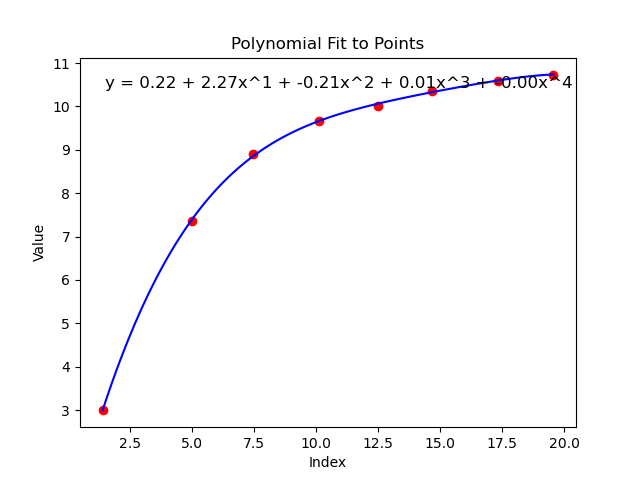

In [ ]:
polynomial = fit_polynomial(sizes_all, Pt_CNs_all, 4)
# log = fit_logarithmic(num_atoms, Pt_CNs_all)

In [ ]:
print(Pt_CNs_all)

[3.0, 6.75, 8.333333333333334, 9.1875, 9.72, 10.083333333333334, 10.346938775510203, 10.546875, 10.703703703703704, 10.83, 10.933884297520661, 11.020833333333334, 11.094674556213018, 11.158163265306122, 11.213333333333333, 11.26171875, 11.304498269896193, 11.342592592592593, 11.376731301939058]


In [ ]:
test = ClusterNeighbor()
test.load_xyz(path = "/Users/juanjuanhuang/Desktop/neighbor/structure_examples/HKUST1_updated.cif")

# test.view_xyz(show_symbol=True)
new = test.expand_cif((3,3,3))
# test.get_CN(center_atom='Pb', CN_atom="O")
test.load_xyz(from_file=False, atom_object=new)
# test.view_xyz(show_symbol=True)
# test.get_CN(center_atom='Pb', CN_atom="O")

In [ ]:
from ase.io import read
from ase.build import make_supercell
import numpy as np

def expand_structure(cif_file, repetitions):
    """
    Expand the structure from a CIF file by repeating the unit cell.
    
    Parameters:
    cif_file (str): Path to the CIF file.
    repetitions (tuple): Number of repetitions along each axis (x, y, z).
    
    Returns:
    Atoms: The expanded structure.
    """
    # Read the CIF file
    structure = read(cif_file)

    # Create the repetition matrix
    repetition_matrix = np.diag(repetitions)

    # Expand the structure
    expanded_structure = make_supercell(structure, repetition_matrix)

    return expanded_structure

# Example usage:
cif_file =  "/Users/juanjuanhuang/Desktop/neighbor/test_Pt/Ptfoil_243678.cif"
# repetitions = (2, 2, 2)  # Repeat twice along each axis
repetitions = (20, 20, 20)  # Repeat twice along each axis

expanded_structure = expand_structure(cif_file, repetitions)

# Save the expanded structure to a new CIF file
write('expanded_structure.cif', expanded_structure)

# Optional: visualize the expanded structure using ASE's viewer
expanded_structure.write('expanded_structure.xyz')
